In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
database = automap_base()
# reflect the tables
database.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
database.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = database.classes.measurement
Station = database.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_calc_temp = calc_temps('2016-01-01', '2016-12-31')
year_calc_temp_df = pd.DataFrame(year_calc_temp, columns = ['temp_min', 'temp_avg', 'temp_max'])

average_temp = year_calc_temp_df['temp_avg']
peak_to_peak = year_calc_temp_df.iloc[0]['temp_max'] - year_calc_temp_df.iloc[0]['temp_min']

year_calc_temp_df

,temp_min,temp_avg,temp_max
0,56.0,74.144218,84.0


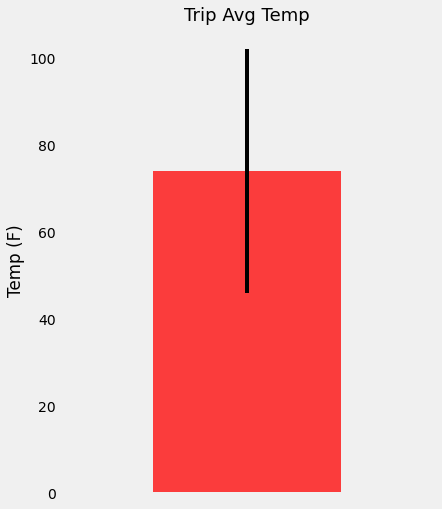

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

average_temp.plot(kind = 'bar', yerr = peak_to_peak, figsize = (6,8), alpha = 0.75, color = 'red')

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp", fontsize=18)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("./Average_temperature.png")
plt.show()

### Daily Rainfall Average

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

Result = session.query(*sel).\
filter(Station.station == Measurement.station).filter(Measurement.date >= '2017-08-01').\
        filter(Measurement.date <= '2017-08-07').group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
stations = pd.DataFrame(Result, columns=["Station","Name", "Latitude", "Longitude", "Elevation", "PrcpSum"])
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36


### Daily Temperature Normals

In [31]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
StarDate = dt.datetime.strptime(start_date, '%Y-%m-%d')
EndDate = dt.datetime.strptime(end_date, '%Y-%m-%d')

travel_dates = []
normals = []


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

while (StarDate <= EndDate):
    travel_dates.append(dt.datetime.strftime(StarDate,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(StarDate, '%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    StarDate = StarDate + dt.timedelta(days = 1)
                                                            
normals                     


[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [44]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
travel_hist = pd.DataFrame(normals, columns=['temp min','temp avg','temp max'])
travel_hist['Date'] = travel_dates
travel_hist = travel_hist.set_index("Date")
travel_hist

,temp min,temp avg,temp max
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


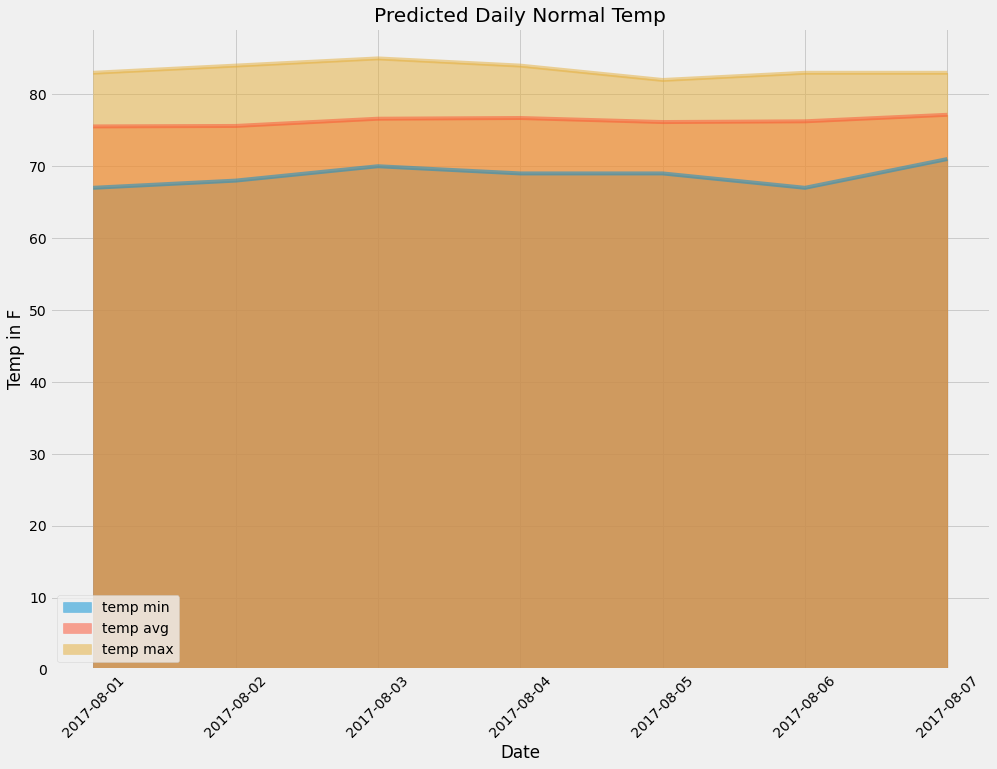

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
travel_hist.plot.area(figsize = (15, 11), stacked=False, title = "Predicted Daily Normal Temp")
plt.xticks(rotation=45)

#Labels
plt.xlabel("Date")
plt.ylabel("Temp in F")
plt.savefig("./Predicted_temperature(min_avg_max).png")
plt.show()

## Close Session

In [49]:
session.close()